# Bagging - Regression

## 보스톤 집값 예측

### 패키지 로딩

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

### 데이터 로드 및 확인 

In [3]:
boston = pd.read_csv('./datasets/HousingData.csv')

In [6]:
# boston.ffill(inplace=True)
# print(boston.isna().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


### 데이터 분할

In [7]:
x = boston.drop('MEDV', axis =1)
y = boston['MEDV']

In [8]:
scaled_x = StandardScaler().fit_transform(x)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.3, random_state=10)

### 모델 생성 및 검증

In [10]:
# n_estimators : tree의 개수
# random_state : 데이터 샘플링 시 사용되는 시드값
model = RandomForestRegressor(n_estimators=200, random_state=0)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=0)

In [12]:
y_hat = model.predict(x_test)
print(f'MAE:{mean_absolute_error(y_test, y_hat):.3f}')
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score: {r2_score(y_test, y_hat):.3f}')

MAE:2.534
RMSE:3.533
R2 Score: 0.872


In [13]:
from sklearn.linear_model import LinearRegression

# 단일 모형(단순 회귀 모형)
lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression()

In [14]:
y_hat = lm.predict(x_test)
print(f'MAE:{mean_absolute_error(y_test, y_hat):.3f}')
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score: {r2_score(y_test, y_hat):.3f}')

MAE:3.684
RMSE:5.432
R2 Score: 0.698


## 파라메터 튜닝

In [15]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[10, 20, 50, 100, 200, 300],
    'bootstrap' : [True, False],
    'max_features' : [2,4,6,8,13]
}
model = RandomForestRegressor()
gs = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')
gs.fit(scaled_x, y)
print('최적 파라메터 조합:', gs.best_params_)

최적 파라메터 조합: {'bootstrap': True, 'max_features': 8, 'n_estimators': 50}


In [16]:
# gs.best_estimator_ : 최적 파라메터 조합에 의해 만들어짐 
y_hat = gs.best_estimator_.predict(x_test)
print(f'MAE:{mean_absolute_error(y_test, y_hat):.3f}')
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'R2 Score: {r2_score(y_test, y_hat):.3f}')

MAE:0.890
RMSE:1.239
R2 Score: 0.984


# Bagging - Classifier

## 와인 품종 분류

### 패키지 로딩

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, classification_report

import numpy as np 
import pandas as pd

### 데이터 로딩 및 확인

In [16]:
wine = load_wine()
# print(wine.DESCR)
x = wine.data
y = wine.target
df = pd.DataFrame(x, columns = wine.feature_names)
# display(df.head())
# print(wine.target_names)
df['class'] = y
display(df.head())

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [17]:
print(df['class'].value_counts())

class
1    71
0    59
2    48
Name: count, dtype: int64


In [18]:
# 스케일링할 필요가 있는지 없는지 확인 - mean 중심으로 확인 (proline에서 편차가 상당히 커지므로 스케일링)
print(df.describe())

          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.9

### 데이터 분할

In [19]:
from sklearn.preprocessing import MinMaxScaler # 정규화 : 모든 값이 0과 1사이의 값으로 바뀜
scaled_x = MinMaxScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.3, random_state=0, stratify=y)

### 모델 생성
- RandomForestClassifier 파라메터
    - bootstrap : 부트스트랩 사용 여부(default = True), True이면 복원 추출된 샘플로 학습하고, False이면 표본 전체를 이용하여 학습
    - criterion : 트리 분할에 사용할 알고리즘 (entropy, gini)
    - max_depth : 나무의 최대 깊이
    - min_samples_split : 노드를 분할하는 데 필요한 최소 샘플 수
    - n_estimators : 사용할 트리의 개수 (default = 100)

In [20]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

## 모델 평가

In [21]:
y_hat = model.predict(x_test)
print(f'정확도:{accuracy_score(y_test, y_hat):.3f}')
report = classification_report(y_test, y_hat)
print(report)

정확도:1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        15

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



In [38]:
# bootstrap = False : value를 다 더하면 전체 samples의 수와 같음
model = RandomForestClassifier(n_estimators=400, min_samples_split = 3, bootstrap =False) # min_samples_spli     t : sample이 3일 때까지 노드를 나눔 (samples = 3일 때 노드 나누면 끝)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, min_samples_split=3, n_estimators=400)

### 트리 시각화

In [23]:
wine.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [39]:
from sklearn.tree import export_graphviz

estimator = model.estimators_[0] # 첫번째 트리
export_graphviz(estimator, out_file='tree.dot', # 파일로 저장 
                feature_names=wine.feature_names,
                class_names=wine.target_names,
                precision=3, # 소수점 정밀도
                filled = True, # class별 노드의 색깔 채우기 
                rounded=True # 노드의 박스 모양을 둥글게 
               )

- graphviz 패키지 설치

In [25]:
#!pip install graphviz

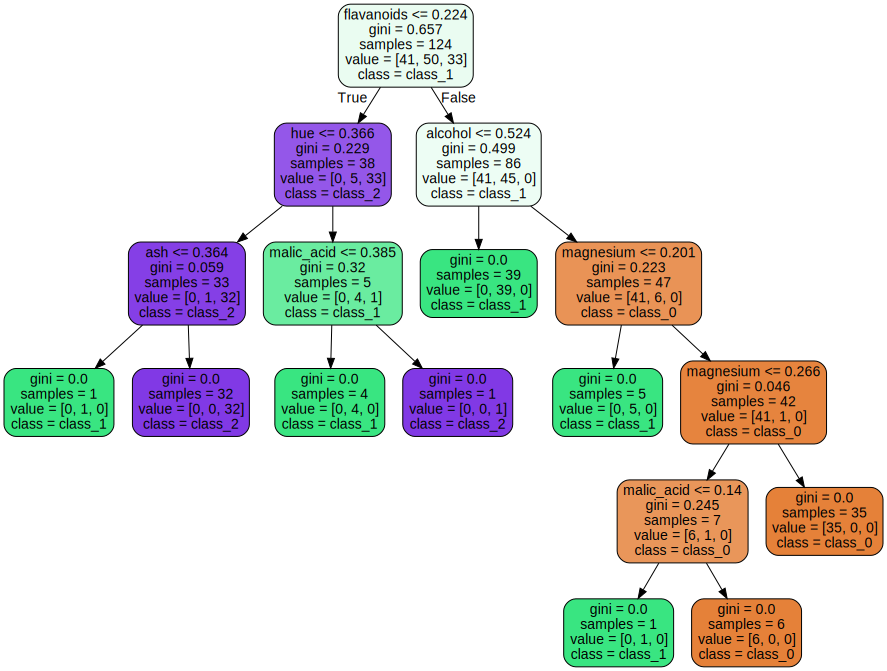

In [40]:
import graphviz

with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)
# gini 계수 : 불평등 지수 -> 잎노드로 갈수록 점점 줄어듦
# value 값 중 다수인 클래스가 class에 선택됨

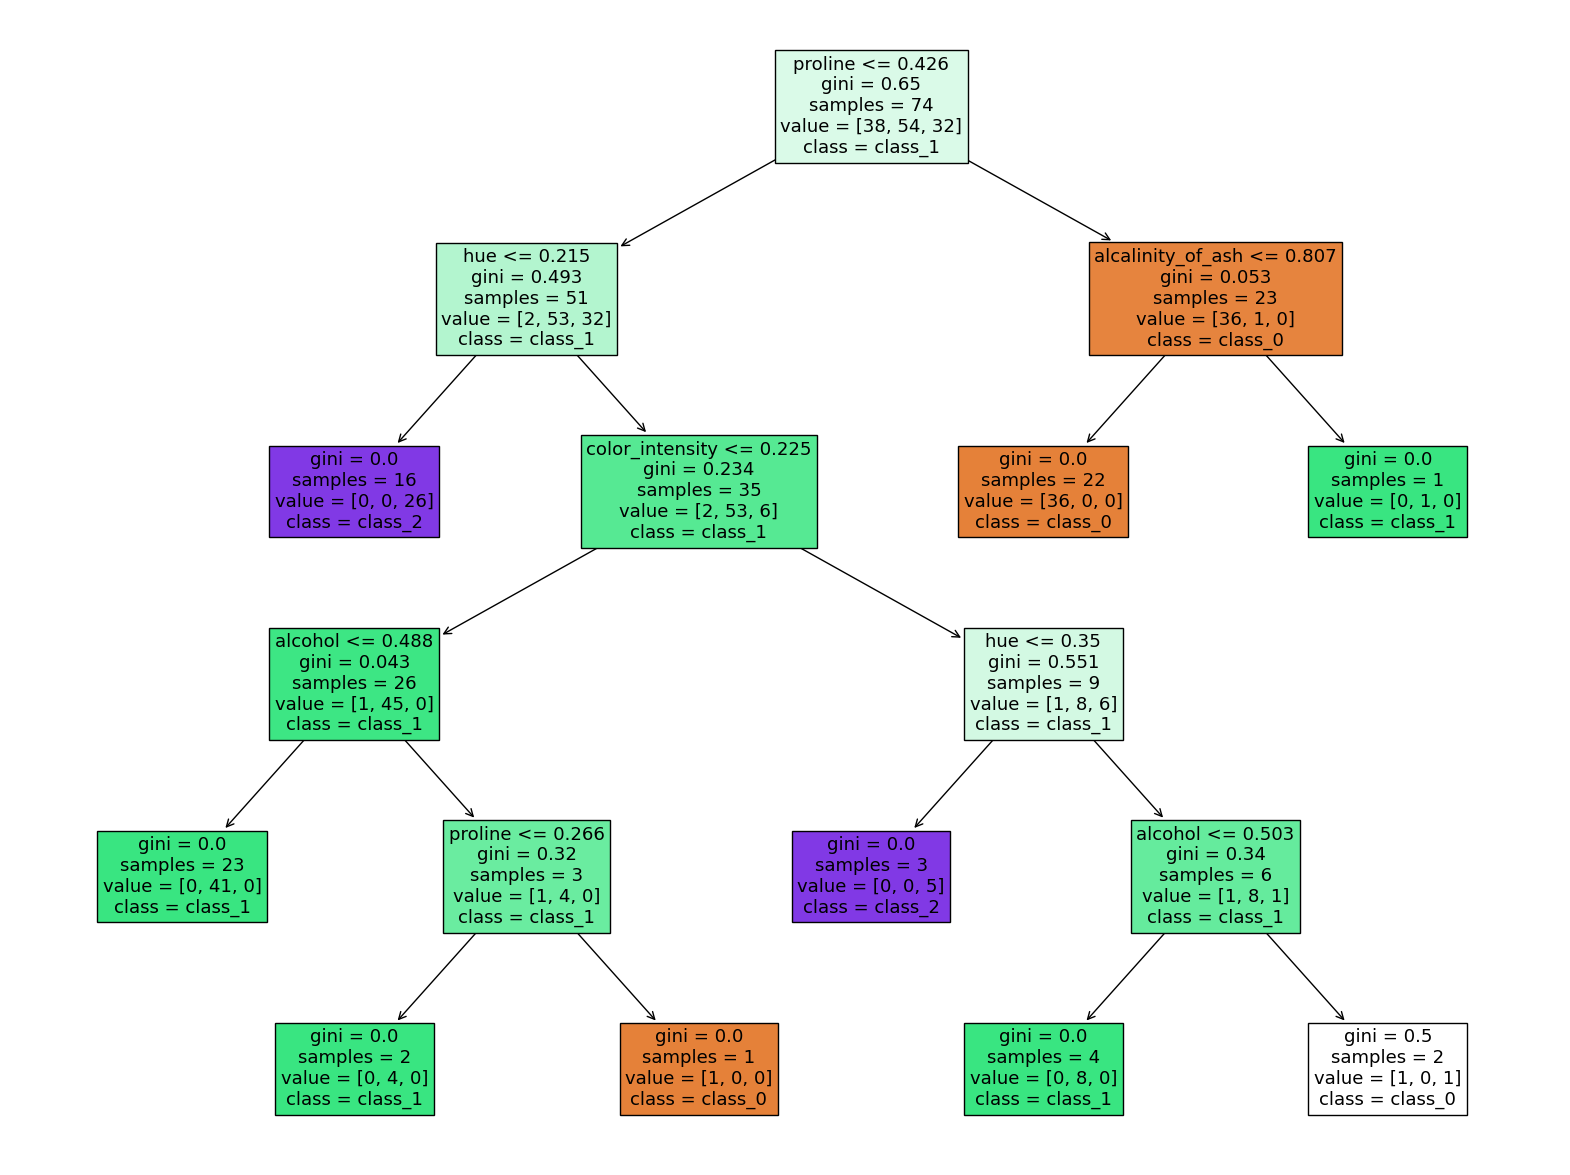

In [37]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 15))
plot_tree(estimator, 
         feature_names=wine.feature_names,
         class_names=wine.target_names,
         filled=True,
         fontsize=13
         )
plt.show()

### 하이퍼 파라메터 튜닝

In [44]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth':[3,5,8,12,15,20],
    'min_samples_split':[2,3,6,20,25],
    'criterion':['gini','entropy']
}

model = RandomForestClassifier()
gs = GridSearchCV(model, params, cv=5, scoring='accuracy')
gs.fit(scaled_x, y)
print('최적의 파라메터:', gs.best_params_)
print('최적의 파라메터 정확도:', gs.best_score_)

최적의 파라메터: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
최적의 파라메터 정확도: 0.9833333333333332


In [46]:
best_estimator = gs.best_estimator_
y_hat = best_estimator.predict(x_test)
print(f'정확도:{accuracy_score(y_test, y_hat):.3f}')

정확도:1.000


### Feature Importance 
- 의사결정나무 알고리즘이 학습을 통해 규칙을 정하는데 있어 피처의 중요도를 나타내는 지표
- 일반적으로 값이 높을수록 해당 피처의 중요도가 높다는 의미로 해석

In [47]:
print(estimator.feature_importances_)

[0.39802321 0.04066608 0.02379624 0.         0.10740858 0.
 0.3669793  0.         0.         0.         0.06312658 0.
 0.        ]


In [48]:
importance = {k:v for k, v in zip(wine.feature_names, estimator.feature_importances_)}
df_importance = pd.DataFrame(pd.Series(importance), columns=['Importance'])
df_importance = df_importance.sort_values('Importance', ascending=False)
display(df_importance)

,Importance
alcohol,0.398023
flavanoids,0.366979
magnesium,0.107409
hue,0.063127
malic_acid,0.040666
ash,0.023796
alcalinity_of_ash,0.000000
total_phenols,0.000000
nonflavanoid_phenols,0.000000
proanthocyanins,0.000000


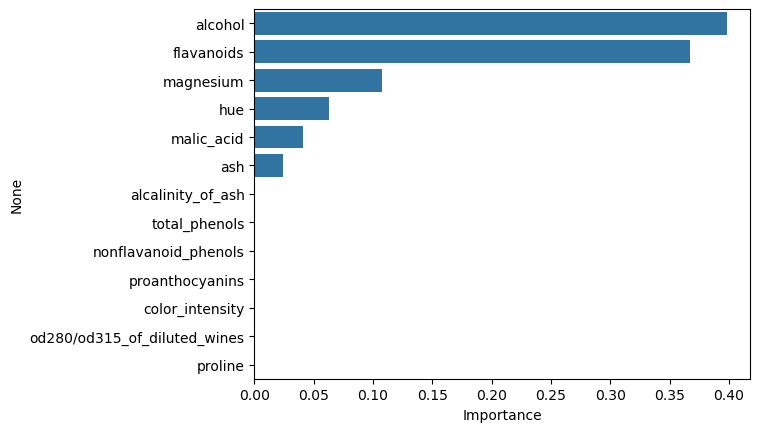

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=df_importance, x = 'Importance', y = df_importance.index)
plt.show()